In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm as tqdm
    
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2025-02-10 21:45:51.362219: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 21:45:52.009300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-10 21:45:52.009421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-10 21:45:52.044486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-10 21:45:52.174469: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tqdm import tqdm as tqdm

In [ ]:
##This cell loads minimagenet with colored images

c_miniimagenet = np.load("miniimagenet_3600_84_84_3.npy")
sbook =c_miniimagenet.reshape((3600,84*84*3))
sbook_mean = np.mean(sbook.flatten())
sbook = sbook - sbook_mean
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[indices]
data_features = sbook

In [ ]:
#This cell loads BW miniimagenet as predominantly used in the paper

sbook = np.load('BW_miniimagenet_3600_60_60_full_rank.npy').reshape((3600,3600))
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[indices]
sbook = sbook - np.mean(sbook.flatten())
data_features=sbook

In [3]:
# load mnist
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../rl-research/vectorhash/data', train=True, download=False, transform=transform)

sbook = trainset.data.numpy()[:3600].reshape((3600,28*28))
sbook_mean = np.mean(sbook.flatten())
sbook = sbook - sbook_mean
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[indices]
data_features = sbook

/home/ezrahuang/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def corrupt_p(codebook,p=0.1,booktype='01'):
  if p==0.:
    return codebook
  rand_indices = np.sign(np.random.uniform(size=codebook.shape)- p )
  if booktype=='-11':
    return np.multiply(codebook,rand_indices)
  elif booktype=='01':
    return abs(codebook - 0.5*(-rand_indices+1))
  elif booktype=='cts':
    return codebook + np.random.normal(0,1,size=codebook.shape)*p
  else:
    print("codebook should be -11; 01; or cts")
    return 0

def get_overlap(x,y,return_all=False,normalized=True):
  if x.shape != y.shape:
    return "error"
  if normalized:
    x = (x/np.linalg.norm(x,axis=1)[:,None])
    y = (y/np.linalg.norm(y,axis=1)[:,None])
    if return_all:
      return np.einsum('ij,ij->i',x,y)
    else:
      return np.average(np.einsum('ij,ij->i',x,y))
  else:
    if return_all:
      np.einsum('ij,ij->i',x,y)
    else:
      return np.average(np.einsum('ij,ij->i',x,y))

def cleanup(s, sbook):
  idx = np.argmax(sbook@s)
  sclean = sbook[idx,:]
  return sclean

def binarize(data,bin_type='01'):
  if bin_type=='01':
    return 0.5*(np.sign(data - 0.5)+1)
  elif bin_type=='-11':
    return np.sign(data)

def get_error(x,y):
  if x.shape != y.shape:
    return "error"
  return np.sum(abs(x-y))/np.prod(x.shape)

def get_mse(x,y):
  if x.shape != y.shape:
    return "error"
  return np.average((x-y)**2.)

### Varying Npatts binary sbook

In [5]:

Npatts_list = np.arange(1,3601,500)
nruns = 1
first_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

verbose=False

for nidx in (range(nruns)):
  for idx,Npatts in enumerate(tqdm(Npatts_list)):
    if verbose:
      print("xxxxx nidx = "+str(nidx))
      print("xxxxx idx = "+str(idx))
      print("xxxxx Npatts = "+str(Npatts))
    Ng=9+16+25
    Np=400
    Ns=3600
    # Npatts=200
    data_shape = Ns
    test_noise_frac=0.0
    test_noise_frac_s=0.1
    test_noise_frac_p=1.0

    sbook = np.sign(np.random.uniform(size=(Npatts,Ns))-0.5)
    
    sperm = sbook[np.random.permutation(Npatts)]
    true_data = sperm[:Npatts]   

    #Autoencoder model below defined with encoder as being s>p and decoder as p>g>p>s so that noise injected after encoder is p noise
    class Autoencoder(Model):
      def __init__(self, Np,Ng,Ns):
        super(Autoencoder, self).__init__()
        self.Np = Np
        self.Ns = Ns
        self.Ng = Ng
        self.encoder = tf.keras.Sequential([
          layers.Dense(Np, activation='tanh'),
          # layers.Dense(Ng, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(Ng, activation='tanh'),
          layers.Dense(Np, activation='tanh'),
          layers.Dense(Ns, activation='tanh')
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    autoencoder = Autoencoder(Np,Ng,Ns)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder.fit(true_data, true_data, epochs=100, verbose=0);
    

    if verbose: print("-------------Testing--1----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    # decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
        encoded_data = autoencoder.encoder(decoded_data).numpy()
        decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data = binarize(decoded_data,bin_type='-11')
    mean_p_val = np.average(np.linalg.norm(encoded_data,axis=1))

    if verbose:
        print("Npatts = "+str(Npatts))
        # print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
        # print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        # print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

        print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--2----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_s))
    
    cts_corrupt = corrupt_p(true_data,p=test_noise_frac_s,booktype='-11')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    # decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--3----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_p))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    encoded_data = encoded_data + test_noise_frac_p*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    # decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    

  0%|          | 0/8 [00:00<?, ?it/s]2025-02-10 21:46:13.775234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-10 21:46:13.983758: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-10 21:46:13.984121: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-10 21:46:13.990381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-10 21:46:13.991017: I e

### Varying Npatts BW miniimagenet sbook

In [ ]:

Npatts_list = np.arange(1,3601,50)
nruns = 3
first_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

verbose=False

for nidx in (range(nruns)):
  for idx,Npatts in enumerate(tqdm.tqdm(Npatts_list)):
    if verbose:
      print("xxxxx nidx = "+str(nidx))
      print("xxxxx idx = "+str(idx))
      print("xxxxx Npatts = "+str(Npatts))
    Ng=9+16+25
    Np=400
    Ns=3600#84*84*3   ### Adjust accordingly if using colored images or BW images
    # Npatts=200
    data_shape = Ns
    test_noise_frac=0.0
    test_noise_frac_s=0.1
    test_noise_frac_p=1.0

    sbook = data_features - np.mean(data_features.flatten())

    sperm = sbook[np.random.permutation(Npatts)]
    true_data = sperm[:Npatts]   

    #Autoencoder model below defined with encoder as being s>p and decoder as p>g>p>s so that noise injected after encoder is p noise
    class Autoencoder(Model):
      def __init__(self, Np,Ng,Ns):
        super(Autoencoder, self).__init__()
        self.Np = Np
        self.Ns = Ns
        self.Ng = Ng
        self.encoder = tf.keras.Sequential([
          layers.Dense(Np, activation='tanh'),
          # layers.Dense(Ng, activation='tanh'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(Ng, activation='tanh'),
          layers.Dense(Np, activation='tanh'),
          layers.Dense(Ns, activation='tanh')
        ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    autoencoder = Autoencoder(Np,Ng,Ns)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder.fit(true_data, true_data, epochs=1000, verbose=0);
    

    if verbose: print("-------------Testing--1----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
        encoded_data = autoencoder.encoder(decoded_data).numpy()
        decoded_data = autoencoder.decoder(encoded_data).numpy()
    mean_p_val = np.average(np.linalg.norm(encoded_data,axis=1))

    if verbose:
        print("Npatts = "+str(Npatts))
        # print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
        # print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        # print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

        print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
        print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--2----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_s))
    
    sbook_std = np.std(sbook.flatten())
    cts_corrupt = true_data + test_noise_frac_s*sbook_std*np.random.normal(0,1,true_data.shape)
    ## mean_s_value = np.average(np.linalg.norm(sbook,axis=1))
    ## cts_corrupt = true_data + test_noise_frac_s*mean_s_value*np.random.normal(0,1,true_data.shape)/np.sqrt(Ns)

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    
    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    
    if verbose: print("-------------Testing--3----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_p))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    encoded_data = encoded_data + test_noise_frac_p*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    
    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    

### Plotting/saving

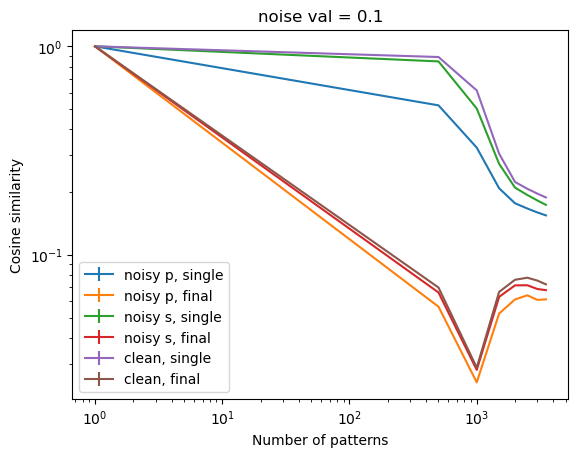

In [ ]:
# plt.plot(Npatts_list,np.average(first_noisy_overlap_list,axis=1), label='noisy, single')
# plt.plot(Npatts_list,np.average(final_noisy_overlap_list,axis=1), label='noisy, final')
# plt.plot(Npatts_list,np.average(first_clean_overlap_list,axis=1), label='clean, single')
# plt.plot(Npatts_list,np.average(final_clean_overlap_list,axis=1), label='clean, final')
plt.errorbar(Npatts_list,np.average(first_noisy_p_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy p, single')
plt.errorbar(Npatts_list,np.average(final_noisy_p_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy p, final')

plt.errorbar(Npatts_list,np.average(first_noisy_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy s, single')
plt.errorbar(Npatts_list,np.average(final_noisy_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy s, final')

plt.errorbar(Npatts_list,np.average(first_clean_overlap_list,axis=1),yerr=np.std(first_clean_overlap_list,axis=1), label='clean, single')
plt.errorbar(Npatts_list,np.average(final_clean_overlap_list,axis=1),yerr=np.std(final_clean_overlap_list,axis=1), label='clean, final')
plt.xlabel('Number of patterns')
plt.ylabel('Cosine similarity')
plt.title('noise val = '+str(test_noise_frac_s))
# plt.xscale('log');
plt.yscale('log');
plt.legend()
# plt.savefig("overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.png")

In [7]:
np.save("first_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", first_clean_overlap_list)
np.save("final_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", final_clean_overlap_list)
np.save("first_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", first_noisy_overlap_list)
np.save("final_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", final_noisy_overlap_list)
np.save("first_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", first_noisy_p_overlap_list)
np.save("final_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_miniimagenet_BW_perm_2.0_noisy_s_p.npy", final_noisy_p_overlap_list)


np.save("Npatts_list_miniimagenet_BW_perm_2.0_noisy_s_p.npy", Npatts_list)


In [8]:
np.save("first_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", first_clean_overlap_list)
np.save("final_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", final_clean_overlap_list)
np.save("first_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", first_noisy_overlap_list)
np.save("final_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", final_noisy_overlap_list)
np.save("first_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", first_noisy_p_overlap_list)
np.save("final_noisy_p_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+"_random_binary_0.1_sflip_1.0_pnoise.npy", final_noisy_p_overlap_list)


np.save("Npatts_list_random_binary_0.1_sflip_1.0_pnoise.npy", Npatts_list)

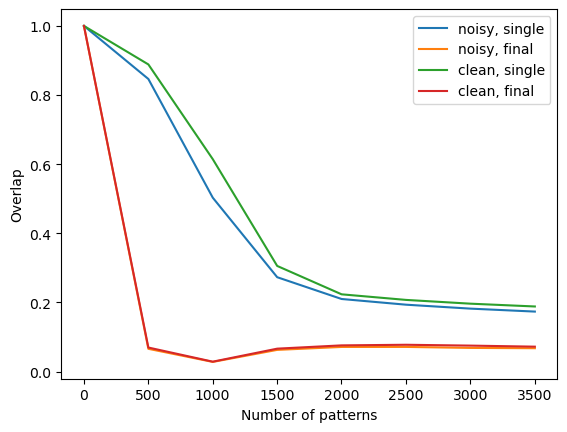

In [13]:
# plt.figure(figsize=(10,8))
plt.plot(Npatts_list,np.average(first_noisy_overlap_list,axis=1), label='noisy, single')
plt.plot(Npatts_list,np.average(final_noisy_overlap_list,axis=1), label='noisy, final')
plt.plot(Npatts_list,np.average(first_clean_overlap_list,axis=1), label='clean, single')
plt.plot(Npatts_list,np.average(final_clean_overlap_list,axis=1), label='clean, final')
# plt.errorbar(Npatts_list,np.average(first_noisy_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy, single')
# plt.errorbar(Npatts_list,np.average(final_noisy_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy, final')
# plt.errorbar(Npatts_list,np.average(first_clean_overlap_list,axis=1),yerr=np.std(first_clean_overlap_list,axis=1), label='clean, single')
# plt.errorbar(Npatts_list,np.average(final_clean_overlap_list,axis=1),yerr=np.std(final_clean_overlap_list,axis=1), label='clean, final')
plt.xlabel('Number of patterns')
plt.ylabel('Overlap')
plt.legend()
plt.savefig("overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+"_nruns_"+str(nruns)+".pdf")

In [ ]:
Ng=18
Np=300
Ns=816
first_clean_overlap_list = np.load("first_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
final_clean_overlap_list = np.load("final_clean_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
first_noisy_overlap_list = np.load("first_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
final_noisy_overlap_list = np.load("final_noisy_overlap_list_Np_"+str(Np)+"_Ns_"+str(Ns)+"_Ng_"+str(Ng)+".npy")
Npatts_list = np.load("Npatts_list.npy")

## iterative increase (not used in paper, qualitatively similar results to above)
 

In [ ]:
import tqdm
Npatts_list = np.arange(1,3601,50)
dNpatts_list = np.diff(Npatts_list)
np.insert(dNpatts_list,0,Npatts_list[0])
# Npatts_list = np.logspace(2,np.log10(3600),25).astype('int')[::-1]
nruns = 3
first_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_clean_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
# first_clean_overlap_not_norm_list = np.zeros((Npatts_list.shape[0],nruns))
# final_clean_overlap_not_norm_list = np.zeros((Npatts_list.shape[0],nruns))
# first_clean_l1_list = np.zeros((Npatts_list.shape[0],nruns))
# final_clean_l1_list = np.zeros((Npatts_list.shape[0],nruns))
# first_clean_mse_list = np.zeros((Npatts_list.shape[0],nruns))
# final_clean_mse_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

first_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))
final_noisy_p_overlap_list = np.zeros((Npatts_list.shape[0],nruns))

verbose=False

for nidx in (range(nruns)):
  Npatts = 0
  Ng=9+16+25
  Np=400
  Ns=3600#84*84*3
  # Npatts=200
  data_shape = Ns
  test_noise_frac=0.0
  test_noise_frac_s=1.
  test_noise_frac_p=1.

  sbook = np.sign(np.random.uniform(size=(max(Npatts_list),Ns))-0.5)

  # sbook = data_features - np.mean(data_features.flatten())


  #sperm = sbook[np.random.permutation(3600)]
  # true_data = sperm[:Npatts]   #data_features[:Npatts]   #double_train_data_cts  #train_data_cts   #noise_aug_train_data  #sbook # bin_train[:Npatts] #

  class Autoencoder(Model):
    def __init__(self, Np,Ng,Ns):
      super(Autoencoder, self).__init__()
      self.Np = Np
      self.Ns = Ns
      self.Ng = Ng
      self.encoder = tf.keras.Sequential([
        layers.Dense(Np, activation='tanh'),
        # layers.Dense(Ng, activation='tanh'),
      ])
      self.decoder = tf.keras.Sequential([
        layers.Dense(Ng, activation='tanh'),
        layers.Dense(Np, activation='tanh'),
        layers.Dense(Ns, activation='tanh')
      ])

    def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

  autoencoder = Autoencoder(Np,Ng,Ns)

  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

  for idx,dNpatts in enumerate(tqdm.tqdm(dNpatts_list)):
    if verbose:
      print("xxxxx nidx = "+str(nidx))
      print("xxxxx idx = "+str(idx))
      print("xxxxx Npatts = "+str(Npatts))

    train_data = sbook[Npatts:Npatts+dNpatts]
    autoencoder.fit(train_data, train_data, epochs=3000, verbose=0);
    Npatts = Npatts + dNpatts


    # if verbose: print("-------------Testing--1----------------")
    # if verbose: print("Testing noise percentage = "+str(test_noise_frac))
    true_data = sbook[:Npatts]
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data = binarize(decoded_data,bin_type='-11')
    mean_p_val = np.average(np.linalg.norm(encoded_data,axis=1))

    if verbose:
      print("Npatts = "+str(Npatts))
      # print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      # print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      # print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      # print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_clean_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_clean_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape],normalized=False)
    # final_clean_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape],normalized=False)

    # first_clean_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_clean_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_clean_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_clean_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    if verbose: print("-------------Testing--2----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_s))
    # cts_corrupt = corrupt_p(true_data,p=test_noise_frac_s,booktype='cts')

    mean_s_value = np.average(np.linalg.norm(true_data,axis=1))
    cts_corrupt = true_data + test_noise_frac_s*mean_s_value*np.random.normal(0,1,true_data.shape)/np.sqrt(Ns)

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape],normalized=False)
    # final_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape],normalized=False)

    # first_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    if verbose: print("-------------Testing--3----------------")
    if verbose: print("Testing noise percentage = "+str(test_noise_frac_p))
    cts_corrupt = corrupt_p(true_data,p=0,booktype='cts')

    encoded_data = autoencoder.encoder(cts_corrupt[:Npatts]).numpy()
    encoded_data = encoded_data + test_noise_frac_p*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data1 = binarize(np.copy(decoded_data),bin_type='-11')
    decoded_data1 = np.copy(decoded_data)
    iters=50
    for _ in range(iters):
      encoded_data = autoencoder.encoder(decoded_data).numpy()
      decoded_data = autoencoder.decoder(encoded_data).numpy()
    #decoded_data = binarize(decoded_data,bin_type='-11')

    if verbose:
      print("Np = "+str(Np))
      print("Ns = "+str(Ns))
      print("Ng = "+str(Ng))
      print("Npatts = "+str(Npatts))


      print("Initial error: " + str(get_mse(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("error after one timestep: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("error after iteration: " + str(get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

      print("Initial overlap: " + str(get_overlap(true_data[:,:data_shape], cts_corrupt[:Npatts,:data_shape])))
      print("overlap after one timestep: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])))
      print("overlap after iteration: " + str(get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])))

    first_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    final_noisy_p_overlap_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape],normalized=False)
    # final_noisy_overlap_not_norm_list[idx,nidx]=get_overlap(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape],normalized=False)

    # first_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_l1_list[idx,nidx]=get_error(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])

    # first_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data1[:Npatts,:data_shape])
    # final_noisy_mse_list[idx,nidx]=get_mse(true_data[:Npatts,:data_shape],decoded_data[:Npatts,:data_shape])


In [ ]:
# plt.plot(Npatts_list,np.average(first_noisy_overlap_list,axis=1), label='noisy, single')
# plt.plot(Npatts_list,np.average(final_noisy_overlap_list,axis=1), label='noisy, final')
# plt.plot(Npatts_list,np.average(first_clean_overlap_list,axis=1), label='clean, single')
# plt.plot(Npatts_list,np.average(final_clean_overlap_list,axis=1), label='clean, final')
plt.errorbar(Npatts_list,np.average(first_noisy_p_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy p, single')
plt.errorbar(Npatts_list,np.average(final_noisy_p_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy p, final')

plt.errorbar(Npatts_list,np.average(first_noisy_overlap_list,axis=1),yerr=np.std(first_noisy_overlap_list,axis=1), label='noisy s, single')
plt.errorbar(Npatts_list,np.average(final_noisy_overlap_list,axis=1),yerr=np.std(final_noisy_overlap_list,axis=1), label='noisy s, final')
plt.errorbar(Npatts_list,np.average(first_clean_overlap_list,axis=1),yerr=np.std(first_clean_overlap_list,axis=1), label='clean, single')
plt.errorbar(Npatts_list,np.average(final_clean_overlap_list,axis=1),yerr=np.std(final_clean_overlap_list,axis=1), label='clean, final')
plt.xlabel('Number of patterns')
plt.ylabel('Cosine similarity')
plt.title('noise val = '+str(test_noise_frac_s))
# plt.plot([1,10],[1,0.1],'k--')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

In [ ]:
# sbook_std = np.std(sbook.flatten())
# # scorrupt_test = corrupt_p(sbook,p=0.2,booktype='cts')
# scorrupt_test = sbook + np.random.normal(0,1,sbook.shape)*1*sbook_std
# #scorrupt_test = 0.5*(scorrupt_test+1)

# sbookf = sbook[:Npatts].reshape((Npatts,60,60))
# scorrupt_test = np.copy(sbookf)
# scorrupt_test[:,:,20:40] = np.random.normal(0,0.1,(Npatts,60,20))
# scorrupt_test = scorrupt_test.reshape((Npatts,3600))

scorrupt_test = corrupt_p(sbook,p=0.1,booktype='-11')

encoded_data = autoencoder.encoder(scorrupt_test[:Npatts]).numpy()

# encoded_data = encoded_data + 0.5*mean_p_val*np.random.normal(0,1,encoded_data.shape)/np.sqrt(Np)
decoded_data = autoencoder.decoder(encoded_data).numpy()
decoded_data1 = np.copy(decoded_data)
iters=100
ovp_ite = np.zeros(iters)
for i in tqdm(range(iters)):
    encoded_data = autoencoder.encoder(decoded_data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    ovp_ite[i] = get_overlap(sbook[:Npatts],decoded_data)

